In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
from data_util import load_data

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
(x_train_all, y_train_all), (x_test, y_test) = load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)


In [4]:
model = keras.models.Sequential()

# selu 激活函数有自归一化的功能，使用selu进行训练

model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='selu', input_shape=(28, 28, 1)))
# (3*3*1 + 1) * 32=320
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='selu'))
# 由于convolutional_1已经学习了32个过滤器。所以数量该层中的可训练参数为(3 * 3 * 32 + 1 )* 32= 9248，依此类推。
model.add(keras.layers.MaxPool2D(pool_size=2))

# pooling之后，图像尺寸减少为原来的一半，所以将filters增加一倍，这样数据拉平之后维度长度不变
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='selu'))
# (3 * 3 * 32 + 1 )* 64= 18496
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='selu'))
# (3 * 3 * 64 + 1 )* 64= 36928 
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='selu'))
# (3*3*64 + 1)*128=73856
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='selu'))
# (3*3*128 + 1)*128=147584
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='selu'))
model.add(keras.layers.Dense(10, activation='softmax'))
# (128 + 1)*10=1290

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [6]:
logdir = './cnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

history = model.fit(x_train_scaled, y_train, epochs=10,
                   validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4324 - accuracy: 0.8427 - val_loss: 0.3188 - val_accuracy: 0.8874
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2888 - accuracy: 0.8959 - val_loss: 0.2803 - val_accuracy: 0.9006
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2412 - accuracy: 0.9117 - val_loss: 0.2446 - val_accuracy: 0.9132
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2065 - accuracy: 0.9256 - val_loss: 0.2421 - val_accuracy: 0.9120
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1794 - accuracy: 0.9356 - val_loss: 0.2288 - val_accuracy: 0.9144
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1535 - accuracy: 0.9453 - val_loss: 0.2304 - val_accuracy: 0.9176
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1310 - accuracy: 0.9529 - val_loss: 0.2414 - val_ac

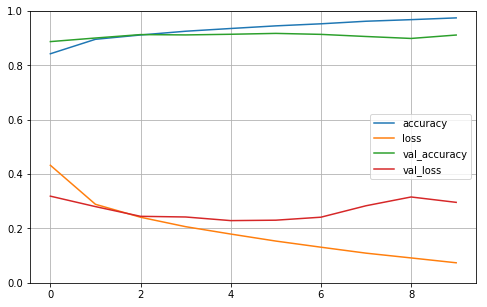

In [9]:
def plot_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curve(history)

In [10]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3127 - accuracy: 0.9033


[0.3127177357673645, 0.9032999873161316]